In [1]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

import random
import math

1.23.5
1.12.1


In [2]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
 
    # encode state into model 
    # output: 3 planes
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [4]:
# nn.Module: base for all neural network modules
# Modules can contain Module, allow to nest them in tree structure
class ResNet(nn.Module):
    # num_resBlocks: the length of our blackbone
    # num_hidden: the hidden size 
    def __init__(self, game, num_resBlocks, num_hidden):
        super().__init__()
        # nn.Sequential: models are added in the order they passed in the constructor
        # chains outputs to inputs sequentially for each subsequenr module
        # finally return uput of last module
        
        # nn.Conv2d: extract features from an input image 
        # in_channels: 3 planes 
        # out_channels: num_hidden 
        # kernel_size=3, padding=1: won't actually change the shape of our game
        
        # BatchNorm2d: transformation maintaing mean output ~ 0 and ouput SD ~ 1
        # increase the speed for us to train
        
        # reLu(x) = max(0,x)
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        # array of different resBlock 
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        # 32 planes
        # linear: 
        # input: tổng tất cả các ô trên 32 planes đó
        # ouput: action_size 
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        # ouput: 1 neuron 
        # nn.Tanh: define output in range [-1, 1]
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        # 3 planes -> convolution -> batch normalize -> reLu 
        # output: 3 processed matrix (same shape as game)
        x = self.startBlock(x)
        
        # loop through residual blocks 
        # out: hidden_layers matrix 
        for resBlock in self.backBone:
            x = resBlock(x)
        
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

# residual block     
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
    
    # skip connection 
    # extract pattern from matrix
    # x -> weight layer -> reLu -> F(x) -> weight layer -> x + F(x) -> reLu   
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

0.9852449893951416
[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
tensor([[[[0., 0., 1.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 1.]]]])


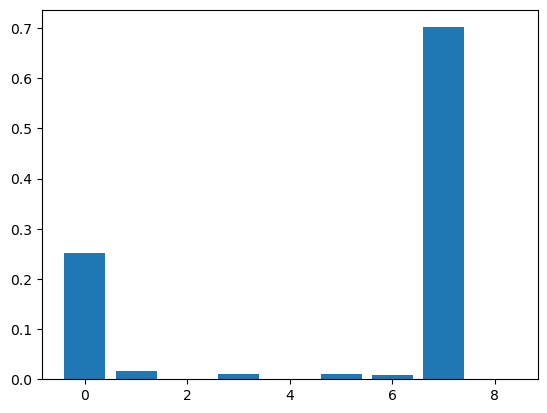

In [5]:
import matplotlib.pyplot as plt

tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, -1)
state = tictactoe.get_next_state(state, 4, -1)
state = tictactoe.get_next_state(state, 6, 1)
state = tictactoe.get_next_state(state, 8, 1)


encoded_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)
model.load_state_dict(torch.load('model_2.pt'))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [6]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        # get from parent when we expand 
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        # we don't immediately visit nodes during expanding
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        # loop all policies 
        # expand all possible directions 
        for action, prob in enumerate(policy):
            # prob=0: expanded before 
            if prob > 0:
                # create new child 
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return child
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

#    2 keys changes: 
   
#    - reach leaf -> predict policy of child states and value for current state -> expand) 
#    - update accessors
#    - use UCB to choose child 
   
#    - use value from model to backpropagate -> remove simulation part
    
    # we don't want to use policy for training immediately -> don't need gradient
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                # input: 3 encoded planes from state game
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                
                # just use for prediction
                # don't want to store the value of gradient of this tensor
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                # ilegal move will have policy value = 0 
                policy *= valid_moves
                # rescale policies 
                policy /= np.sum(policy)
                
                # just want to have one float value 
                value = value.item()
                
                # use policy for expansion
                node.expand(policy)
            
            # use value for backpropagation 
            node.backpropagate(value)    
            
            
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        

In [8]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
 
 # 2 components: the save part and the training part
 
    def selfPlay(self):
        # memory inside of 1 own self-play game
        memory = []
        player = 1
        # define an initial state
        state = self.game.get_initial_state()
        
        while True:
            # MCTS base on current state -> p & v -> sample action from distribution of action probability -> use that action to play 
            # -> new state -> is the state is terminal -> end: return all of states to memory 
            # data store in tuples form: (state, action probabilities of MCTS, final outcome)
            
            # when call mcts.search, we always are player 1 -> get neutral state 
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
            
            memory.append((neutral_state, action_probs, player))
            
            action = np.random.choice(self.game.action_size, p=action_probs)
            
            state = self.game.get_next_state(state, action, player)
            
            value, is_terminal = self.game.get_value_and_terminated(state, action)
            
            if is_terminal:
                returnMemory = []
                # loop memory 
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    # hist_player is first player ?
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)
                
    def train(self, memory):
        # shuffle training data, not get the same batches all the time 
        random.shuffle(memory)
        
        # loop over all of memory 
        # for each vatchIndex, sample a whole batch of # samples -> train 
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            # take a sample from memory
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])] # Change to memory[batchIdx:batchIdx+self.args['batch_size']] in case of an error
            # transpose our sample: list of tuples -> list of states, list of policies, list of targets 
            state, policy_targets, value_targets = zip(*sample)
            
            # change into numpy array
            # .reshape(-1, 1): list of float values -> each of these value actually in own sub-array --> easy to compare with the output of model
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            # change into tensors 
            state = torch.tensor(state, dtype=torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
            value_targets = torch.tensor(value_targets, dtype=torch.float32)
            
            # get policy, value from model by letting it predict the state 
            # purpose: reduce the different between (policy, mcst-distribution) and (value, final reward)
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            # need to minimize this loss by backpropagation 
            loss = policy_loss + value_loss
            
            # pytorch does all big propagation for us 
            # instead of setting to 0, set the grads to None -> improve performance
            # did not receive a gradient 
            self.optimizer.zero_grad()
            # the gradients are stored by tensor themselves once call backward() on loss
            # accumulates the gradient for each parameter 
            loss.backward()
            # makes the optimiser iterate over all tensors -> update and use internally store grad to update their values 
            self.optimizer.step() 
    
    # use when we want to start the cycle of continuous learning
    # where we run sort of play -> get data -> use data to train and optimize model
    # close if play agian with the model that is much smarter 
    def learn(self):
        # loop all iterations 
        for iteration in range(self.args['num_iterations']):
            # each iter: store training data 
            memory = []
            
            self.model.eval()
            # loop over all self-play games
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                # for each iter -> extend data got out of selfPlay method 
                memory += self.selfPlay()
            
            # training part
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            # store weights (learnable para) of our model, a dictionary object that maps each layer to its parameter tensor 
            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            # store static of optimizer 
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

In [9]:
tictactoe = TicTacToe()

model = ResNet(tictactoe, 4, 64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()


while True:
    print(state)
    
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.  0.  1.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
valid_moves [0, 1, 3, 5, 6, 7, 8]
[[ 0.  0.  1.]
 [ 0. -1.  1.]
 [ 0.  0.  0.]]
[[ 0.  0.  1.]
 [ 0. -1.  1.]
 [ 0.  0. -1.]]
valid_moves [0, 1, 3, 6, 7]
[[ 0.  0.  1.]
 [ 0. -1.  1.]
 [ 1.  0. -1.]]
[[-1.  0.  1.]
 [ 0. -1.  1.]
 [ 1.  0. -1.]]
-1 won
